In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, precision_score, recall_score


sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)


file_path = 'data/База.csv'
try:
    df_raw = pd.read_csv(file_path, sep=';')
    print(f"Данные успешно загружены. Форма: {df_raw.shape}")
except FileNotFoundError:
    print(f"!!! КРИТИЧЕСКАЯ ОШИБКА: Файл не найден по пути '{file_path}'.")

Данные успешно загружены. Форма: (5519, 21)


In [ ]:

df_filtered = df_raw[df_raw['ВидПомещения'].str.strip() == 'жилые помещения'].copy()
final_statuses = ['Продана', 'Свободна']
df_final = df_filtered[df_filtered['СледующийСтатус'].isin(final_statuses)].copy()

df_final['target'] = df_final['СледующийСтатус'].map({'Продана': 1, 'Свободна': 0})
df_final.drop(['УИД_Брони', 'ВидПомещения', 'СледующийСтатус'], axis=1, inplace=True)
print(f"Данные отфильтрованы. Размер для обработки: {df_final.shape}")

Данные отфильтрованы. Размер для обработки: (3944, 19)


In [ ]:


df_processed = df_final.copy()
print(f"\n--- Начало очистки. Размер: {df_processed.shape} ---")

numeric_cols = [
    'ПродаваемаяПлощадь', 'Этаж', 'СтоимостьНаДатуБрони', 
    'СкидкаНаКвартиру', 'ФактическаяСтоимостьПомещения', 'Тип'
]
for col in numeric_cols:
    if df_processed[col].dtype == 'object':
        if col == 'Тип':
            df_processed[col] = df_processed[col].str.replace('к', '', regex=False)
        df_processed[col] = df_processed[col].str.replace(',', '.', regex=False)
    
    df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce')
print("Числовые столбцы преобразованы.")


binary_cols_map = {
    'ВременнаяБронь': {'да': 1, 'нет': 0},
    'СделкаАН': {'да': 1, 'нет': 0},
    'ИнвестиционныйПродукт': {'да': 1, 'нет': 0},
    'Привилегия': {'да': 1, 'нет': 0}
}
for col, mapping in binary_cols_map.items():
    df_processed[col] = df_processed[col].str.lower().map(mapping)

df_processed['ИсточникБрони'] = df_processed['ИсточникБрони'].map({'ручная': 0, 'МП': 1})

df_processed['ТипСтоимости'] = df_processed['ТипСтоимости'].str.contains('100%', na=False).astype(int)
df_processed['ВариантОплаты'] = df_processed['ВариантОплаты'].str.contains('Единовременная', na=False).astype(int)
print("Бинарные признаки закодированы.")


df_processed = pd.get_dummies(df_processed, columns=['Город', 'Статус лида (из CRM)'], drop_first=True, dtype=int)
print("Категориальные признаки закодированы.")


df_processed.drop(['ДатаБрони', 'ВремяБрони', 'ВариантОплатыДоп'], axis=1, inplace=True, errors='ignore')

print("\n--- Заполнение пропусков ---")
for col in df_processed.columns:
    if df_processed[col].isnull().any():
        if pd.api.types.is_numeric_dtype(df_processed[col]):
            median_val = df_processed[col].median()
            df_processed[col] = df_processed[col].fillna(median_val)
            print(f"Числовой столбец '{col}': пропуски заменены медианой ({median_val:.2f})")
        else: # Этот блок теперь, скорее всего, не понадобится, но оставим для надежности
            mode_val = df_processed[col].mode()[0]
            df_processed[col] = df_processed[col].fillna(median_val)
            print(f"Категориальный столбец '{col}': пропуски заменены модой ('{mode_val}')")

if df_processed.isnull().sum().sum() == 0:
    print(f"\nОчистка завершена успешно. Финальный размер: {df_processed.shape}")
else:
    raise RuntimeError("ОШИБКА: После очистки все еще остались пропуски!")


--- Начало очистки. Размер: (3944, 19) ---
Числовые столбцы преобразованы.
Бинарные признаки закодированы.
Категориальные признаки закодированы.

--- Заполнение пропусков ---
Числовой столбец 'Тип': пропуски заменены медианой (2.00)
Числовой столбец 'ПродаваемаяПлощадь': пропуски заменены медианой (60.50)
Числовой столбец 'СкидкаНаКвартиру': пропуски заменены медианой (111876.00)

Очистка завершена успешно. Финальный размер: (3944, 24)


In [ ]:

epsilon = 1e-6
df_processed['ЦенаЗаМетр'] = df_processed['ФактическаяСтоимостьПомещения'] / (df_processed['ПродаваемаяПлощадь'] + epsilon)
initial_price = df_processed['ФактическаяСтоимостьПомещения'] + df_processed['СкидкаНаКвартиру']
df_processed['СкидкаПроцент'] = (df_processed['СкидкаНаКвартиру'] / (initial_price + epsilon)) * 100
print("Созданы новые признаки.")

y = df_processed['target']
X = df_processed.drop('target', axis=1)
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled['СкидкаНаКвартиру'] = (X_scaled['СкидкаНаКвартиру'] - 0.5)
print(f"Баланс классов: \n{y.value_counts(normalize=True)}")
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42, stratify=y
)
print(f"Данные готовы. Train: {X_train.shape}, Test: {X_test.shape}")


def evaluate_model(model, model_name):
    print(f"\n--- Оценка модели: {model_name} ---")
    model.fit(X_train, y_train)
    y_pred_test = model.predict(X_test)
    precision = precision_score(y_test, y_pred_test)
    recall = recall_score(y_test, y_pred_test)
    f1 = f1_score(y_test, y_pred_test)
    print(f"  Precision: {precision:.4f} | Recall: {recall:.4f} | F1-мера: {f1:.4f}")
    return {'model': model_name, 'precision': precision, 'recall': recall, 'f1_score': f1}

knn = KNeighborsClassifier()
knn_results = evaluate_model(knn, "K-Nearest Neighbors (KNN)")

tree = DecisionTreeClassifier(random_state=42)
tree_results = evaluate_model(tree, "Decision Tree")

print("\n--- Итоговое сравнение моделей ---")
results_df = pd.DataFrame([knn_results, tree_results]).sort_values('f1_score', ascending=False)
display(results_df)

Созданы новые признаки.
Баланс классов: 
target
0    0.710953
1    0.289047
Name: proportion, dtype: float64
Данные готовы. Train: (2760, 25), Test: (1184, 25)

--- Оценка модели: K-Nearest Neighbors (KNN) ---
  Precision: 0.7491 | Recall: 0.6199 | F1-мера: 0.6784

--- Оценка модели: Decision Tree ---
  Precision: 0.8018 | Recall: 0.7690 | F1-мера: 0.7851

--- Итоговое сравнение моделей ---


,model,precision,recall,f1_score
1,Decision Tree,0.801829,0.769006,0.785075
0,K-Nearest Neighbors (KNN),0.749117,0.619883,0.678400


--- Визуализация выбросов до удаления ---


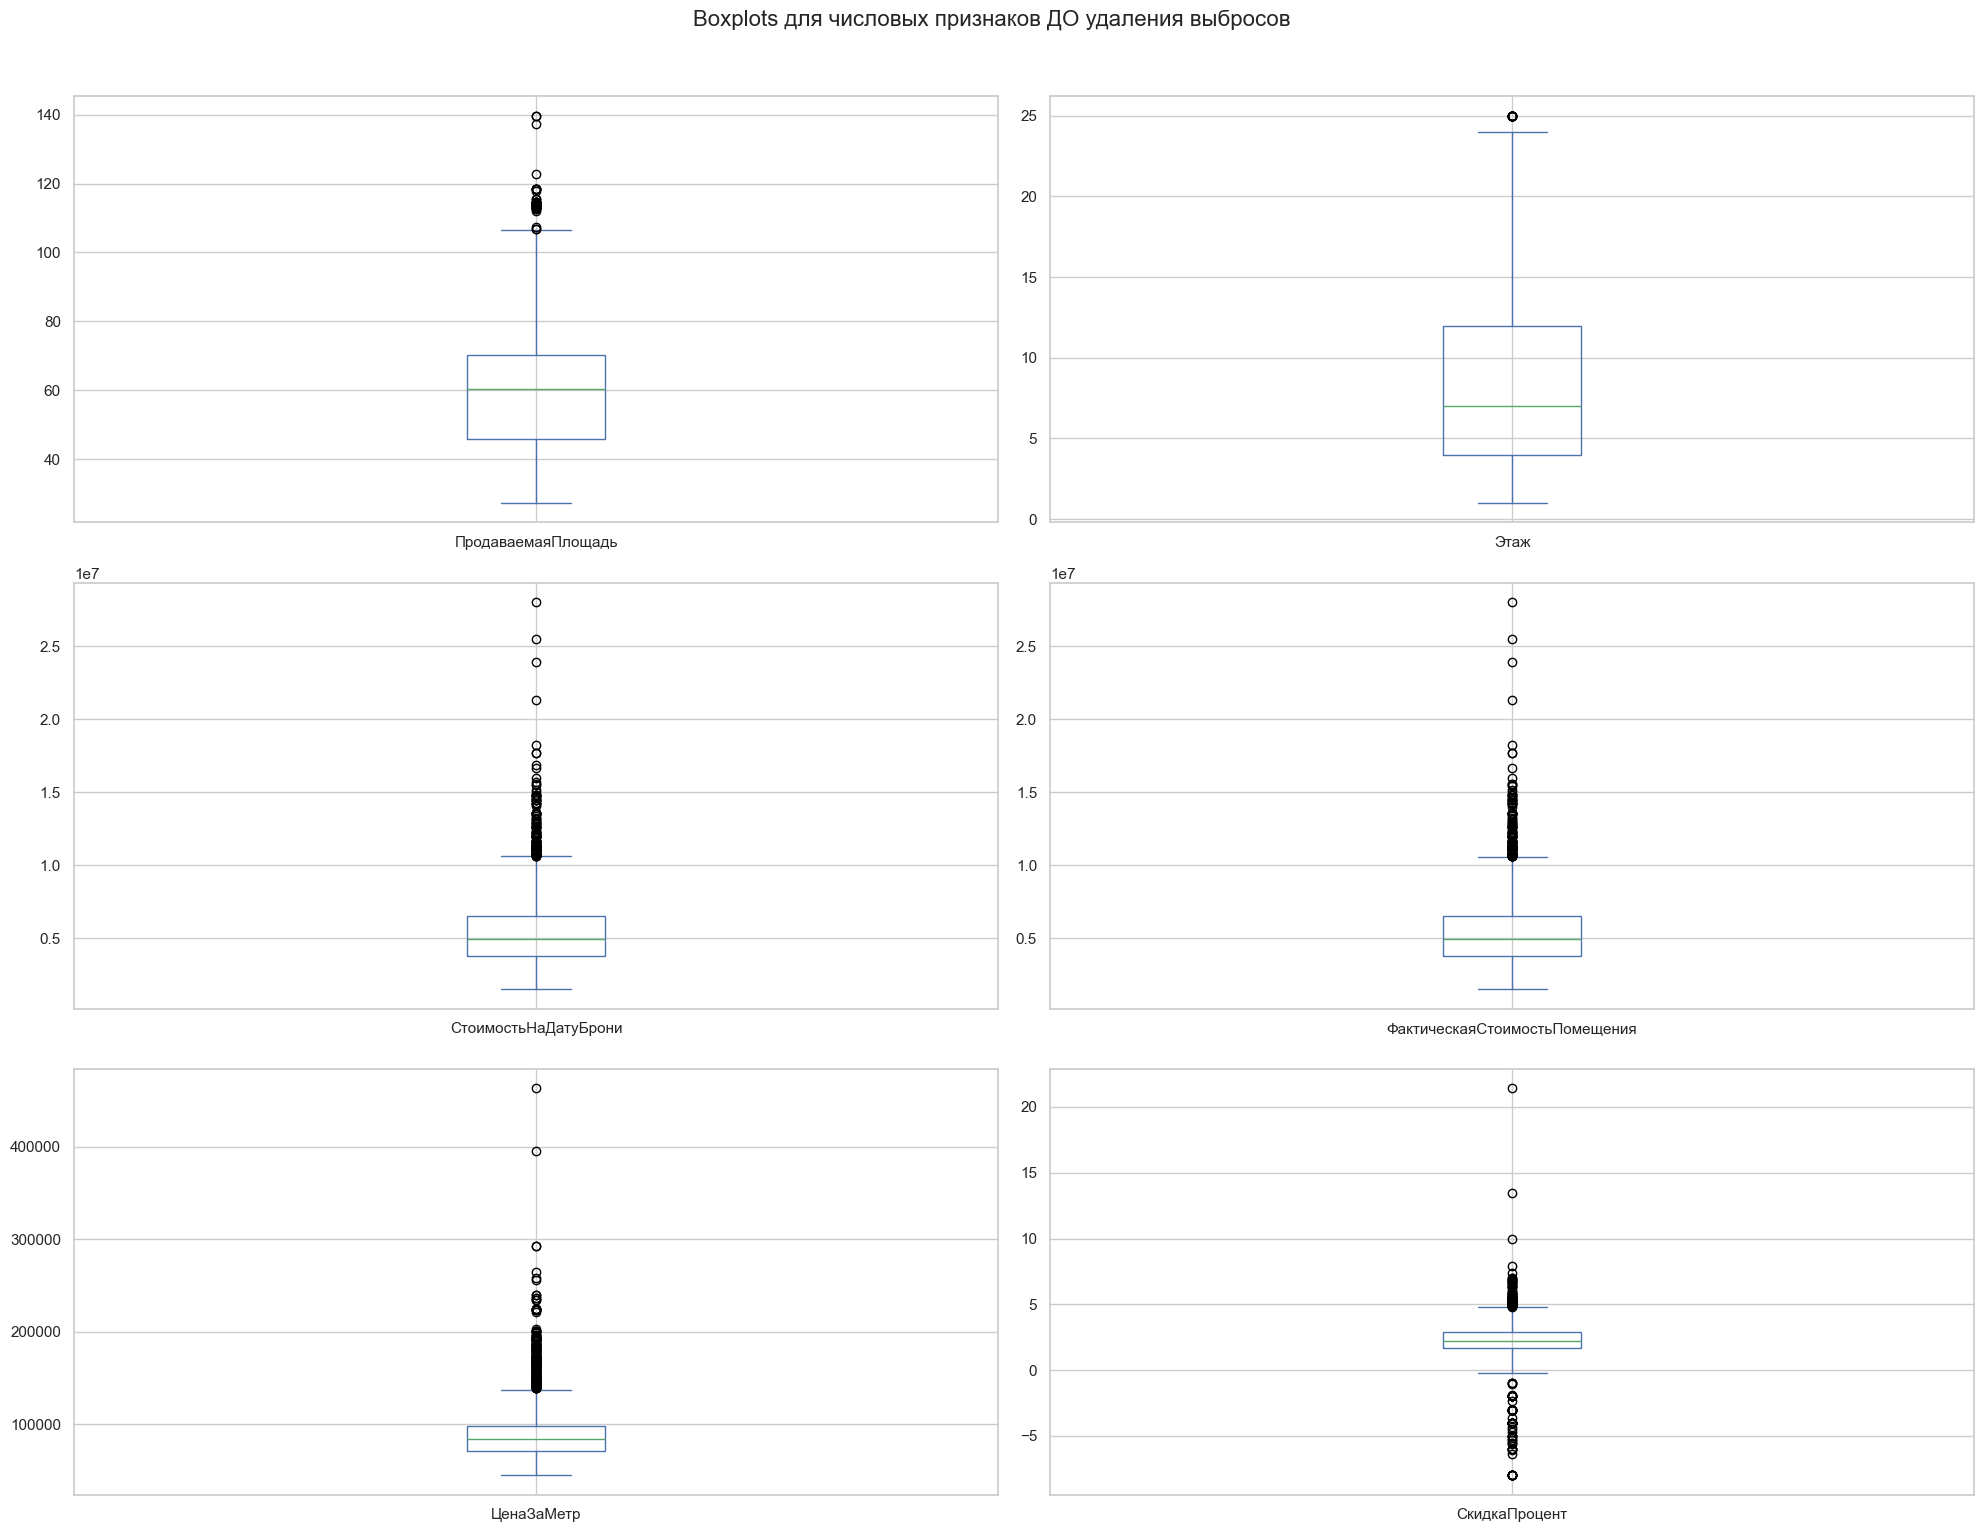


--- Процесс удаления выбросов ---
Исходный размер датасета: 3944 строк.
Размер после удаления выбросов по 'ФактическаяСтоимостьПомещения': 3802 строк.
Удалено: 142 строк.

--- Переобучение моделей на данных БЕЗ выбросов ---

--- Оценка модели: KNN (без выбросов) ---
  Precision: 0.7491 | Recall: 0.6199 | F1-мера: 0.6784

--- Оценка модели: Decision Tree (без выбросов) ---
  Precision: 0.8018 | Recall: 0.7690 | F1-мера: 0.7851

--- Вывод по удалению выбросов ---
Сравните F1-меру моделей до и после удаления выбросов.
Часто удаление выбросов немного снижает F1-меру, но делает модель более стабильной и менее склонной к переобучению на аномалиях.


In [ ]:

print("--- Визуализация выбросов до удаления ---")
numeric_features_for_boxplot = ['ПродаваемаяПлощадь', 'Этаж', 'СтоимостьНаДатуБрони', 'ФактическаяСтоимостьПомещения', 'ЦенаЗаМетр', 'СкидкаПроцент']
X[numeric_features_for_boxplot].plot(kind='box', subplots=True, layout=(3, 2), figsize=(20, 15), sharex=False, sharey=False)
plt.suptitle("Boxplots для числовых признаков ДО удаления выбросов", y=1.02, fontsize=16)
plt.tight_layout()
plt.show()


print("\n--- Процесс удаления выбросов ---")
Q1 = df_processed['ФактическаяСтоимостьПомещения'].quantile(0.25)
Q3 = df_processed['ФактическаяСтоимостьПомещения'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR


df_no_outliers = df_processed[(df_processed['ФактическаяСтоимостьПомещения'] >= lower_bound) & (df_processed['ФактическаяСтоимостьПомещения'] <= upper_bound)]

print(f"Исходный размер датасета: {df_processed.shape[0]} строк.")
print(f"Размер после удаления выбросов по 'ФактическаяСтоимостьПомещения': {df_no_outliers.shape[0]} строк.")
print(f"Удалено: {df_processed.shape[0] - df_no_outliers.shape[0]} строк.")


y_no_outliers = df_no_outliers['target']
X_no_outliers = df_no_outliers.drop('target', axis=1)

scaler_no_outliers = MinMaxScaler()
X_scaled_no_outliers = pd.DataFrame(scaler_no_outliers.fit_transform(X_no_outliers), columns=X_no_outliers.columns)
X_scaled_no_outliers['СкидкаНаКвартиру'] = (X_scaled_no_outliers['СкидкаНаКвартиру'] - 0.5)

X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(
    X_scaled_no_outliers, y_no_outliers, test_size=0.3, random_state=42, stratify=y_no_outliers
)

print("\n--- Переобучение моделей на данных БЕЗ выбросов ---")
knn_no_outliers_results = evaluate_model(KNeighborsClassifier(), "KNN (без выбросов)")
tree_no_outliers_results = evaluate_model(DecisionTreeClassifier(random_state=42), "Decision Tree (без выбросов)")

# 4. Вывод
print("\n--- Вывод по удалению выбросов ---")
print("Сравните F1-меру моделей до и после удаления выбросов.")
print("Часто удаление выбросов немного снижает F1-меру, но делает модель более стабильной и менее склонной к переобучению на аномалиях.")

--- Подбор оптимального k для KNN ---


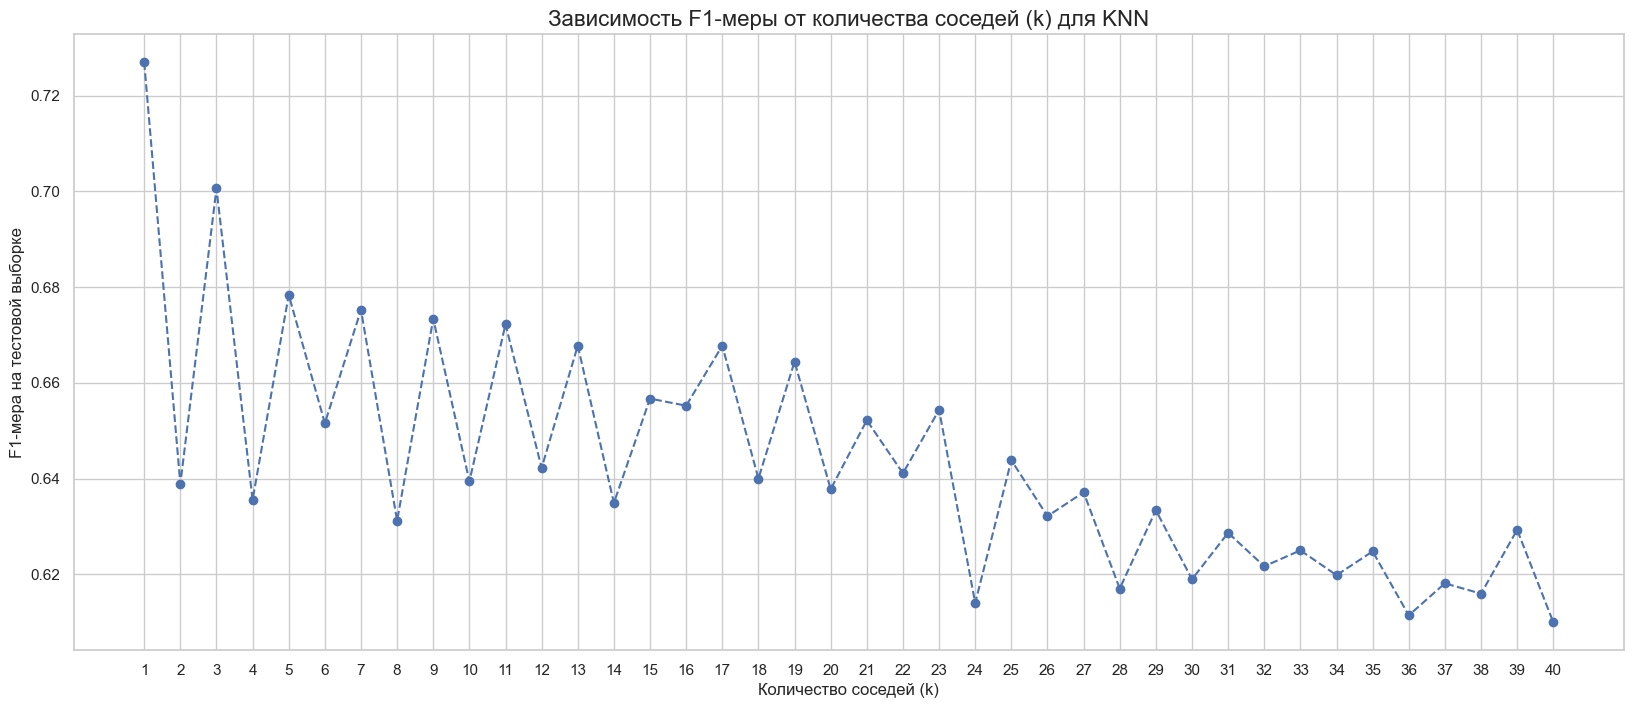

Оптимальное значение k для KNN: 1 (F1-мера: 0.7270)

--- Подбор оптимальной глубины для Decision Tree ---


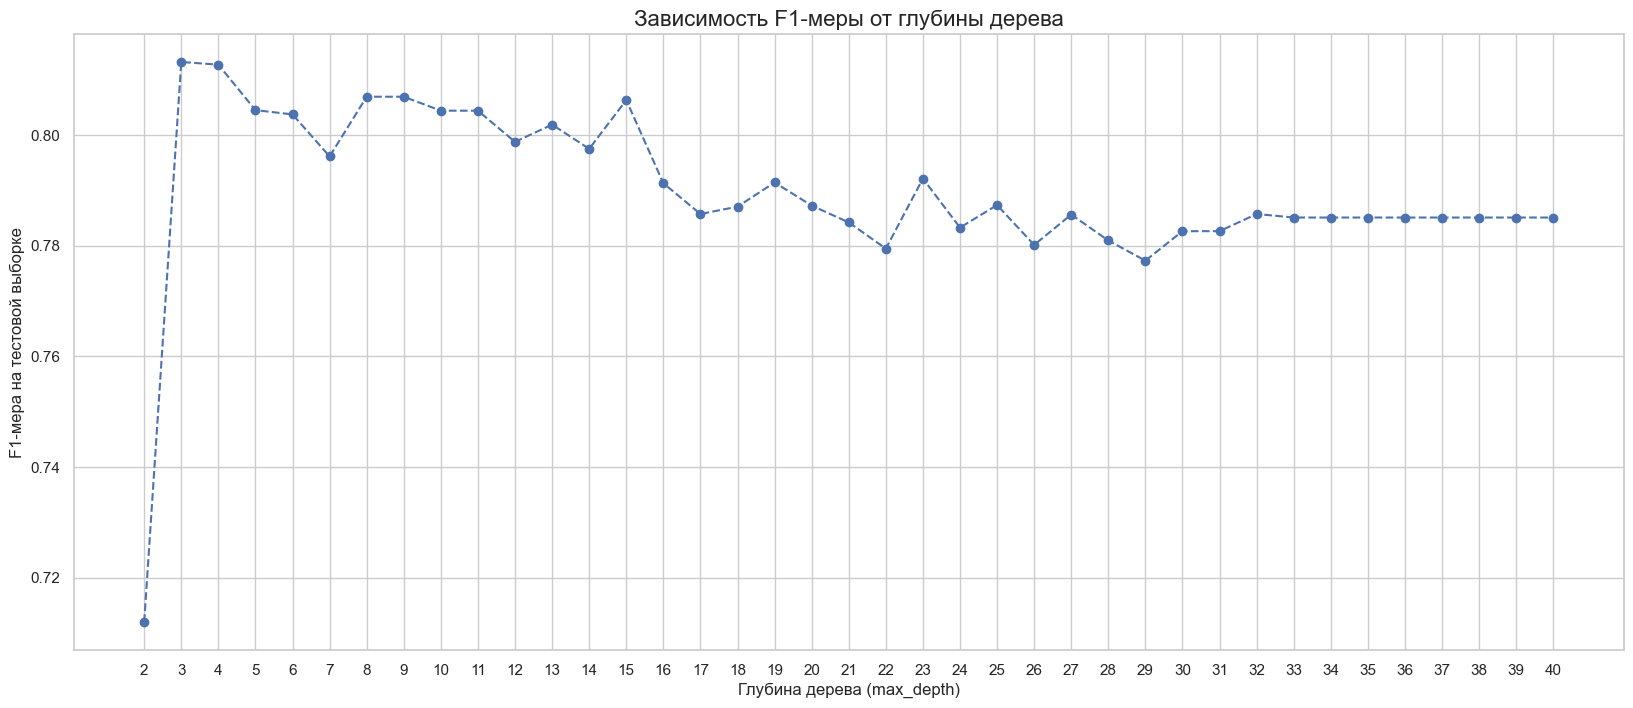

Оптимальное значение max_depth для Decision Tree: 3 (F1-мера: 0.8132)


In [ ]:

print("--- Подбор оптимального k для KNN ---")
k_range = range(1, 41)
f1_scores_knn = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1_scores_knn.append(f1_score(y_test, y_pred))


plt.figure(figsize=(20, 8))
plt.plot(k_range, f1_scores_knn, marker='o', linestyle='--')
plt.title('Зависимость F1-меры от количества соседей (k) для KNN', fontsize=16)
plt.xlabel('Количество соседей (k)', fontsize=12)
plt.ylabel('F1-мера на тестовой выборке', fontsize=12)
plt.xticks(k_range)
plt.grid(True)
plt.show()


optimal_k = k_range[np.argmax(f1_scores_knn)]
print(f"Оптимальное значение k для KNN: {optimal_k} (F1-мера: {max(f1_scores_knn):.4f})")


print("\n--- Подбор оптимальной глубины для Decision Tree ---")
depth_range = range(2, 41)
f1_scores_tree = []

for depth in depth_range:
    tree = DecisionTreeClassifier(max_depth=depth, random_state=42)
    tree.fit(X_train, y_train)
    y_pred = tree.predict(X_test)
    f1_scores_tree.append(f1_score(y_test, y_pred))


plt.figure(figsize=(20, 8))
plt.plot(depth_range, f1_scores_tree, marker='o', linestyle='--')
plt.title('Зависимость F1-меры от глубины дерева', fontsize=16)
plt.xlabel('Глубина дерева (max_depth)', fontsize=12)
plt.ylabel('F1-мера на тестовой выборке', fontsize=12)
plt.xticks(depth_range)
plt.grid(True)
plt.show()


optimal_depth = depth_range[np.argmax(f1_scores_tree)]
print(f"Оптимальное значение max_depth для Decision Tree: {optimal_depth} (F1-мера: {max(f1_scores_tree):.4f})")

In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


log_reg = LogisticRegression(max_iter=2000, random_state=42)
log_reg_results = evaluate_model(log_reg, "Logistic Regression")


svm = LinearSVC(max_iter=5000, random_state=42, dual=False)
svm_results = evaluate_model(svm, "SVM (LinearSVC)")


--- Оценка модели: Logistic Regression ---
  Precision: 0.8670 | Recall: 0.5526 | F1-мера: 0.6750

--- Оценка модели: SVM (LinearSVC) ---
  Precision: 0.8750 | Recall: 0.5731 | F1-мера: 0.6926


In [ ]:

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC


log_reg = LogisticRegression(max_iter=2000, random_state=42)
log_reg_results = evaluate_model(log_reg, "Logistic Regression")


svm = LinearSVC(max_iter=5000, random_state=42, dual=False)
svm_results = evaluate_model(svm, "SVM (LinearSVC)")


--- Оценка модели: Logistic Regression ---
  Precision: 0.8670 | Recall: 0.5526 | F1-мера: 0.6750

--- Оценка модели: SVM (LinearSVC) ---
  Precision: 0.8750 | Recall: 0.5731 | F1-мера: 0.6926


In [ ]:

knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal_results = evaluate_model(knn_optimal, "KNN (Optimal k)")

tree_optimal = DecisionTreeClassifier(max_depth=optimal_depth, random_state=42)
tree_optimal_results = evaluate_model(tree_optimal, "Decision Tree (Optimal depth)")



all_results = pd.DataFrame([
    knn_results,
    tree_results,
    knn_no_outliers_results,
    tree_no_outliers_results,
    knn_optimal_results,
    tree_optimal_results,
    log_reg_results,
    svm_results
])


all_results_sorted = all_results.sort_values('f1_score', ascending=False).reset_index(drop=True)

print("\n\n--- 🏆 ФИНАЛЬНАЯ ТАБЛИЦА СРАВНЕНИЯ МОДЕЛЕЙ 🏆 ---")
display(all_results_sorted)

print(f"\n🏆 Абсолютно лучшая модель по F1-мере: '{all_results_sorted.iloc[0]['model']}' с результатом {all_results_sorted.iloc[0]['f1_score']:.4f}")


--- Оценка модели: KNN (Optimal k) ---
  Precision: 0.7508 | Recall: 0.7047 | F1-мера: 0.7270

--- Оценка модели: Decision Tree (Optimal depth) ---
  Precision: 0.8780 | Recall: 0.7573 | F1-мера: 0.8132


--- 🏆 ФИНАЛЬНАЯ ТАБЛИЦА СРАВНЕНИЯ МОДЕЛЕЙ 🏆 ---


,model,precision,recall,f1_score
0,Decision Tree (Optimal depth),0.877966,0.757310,0.813187
1,Decision Tree,0.801829,0.769006,0.785075
2,Decision Tree (без выбросов),0.801829,0.769006,0.785075
3,KNN (Optimal k),0.750779,0.704678,0.726998
4,SVM (LinearSVC),0.875000,0.573099,0.692580
5,K-Nearest Neighbors (KNN),0.749117,0.619883,0.678400
6,KNN (без выбросов),0.749117,0.619883,0.678400
7,Logistic Regression,0.866972,0.552632,0.675000



🏆 Абсолютно лучшая модель по F1-мере: 'Decision Tree (Optimal depth)' с результатом 0.8132
